In [1]:
import os

KERNEL_GATEWAY = os.environ.get('KERNEL_GATEWAY', False)

In [2]:
import matplotlib
if not KERNEL_GATEWAY:
    %matplotlib inline
else:
    matplotlib.use('agg')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
import json
import itertools
import numpy as np

The iris dataset consists of measurements of three different species of irises.
scikit-learn embeds a copy of the iris CSV file along with a helper function to load it into numpy arrays.

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()

print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [22]:
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [23]:
print("Train Data shape: {}, Test Data shape: {}".format(iris.data.shape, iris.target.shape))

Train Data shape: (150, 4), Test Data shape: (150,)


## Exploring the dataset

In [24]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


In [25]:
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


#### Utilities for the gateway

In [26]:
GATEWAY = {
    'request':{
        'body': {},
        'path': {},
        'args': {},
        'headers': {}
    },
    'response': None
}

In [27]:
# testing
GATEWAY['request']['args'] = {'model':0, 'variables':'5,2'}
REQUEST  = json.dumps(GATEWAY['request'])

In [28]:
import io
import urllib
import base64

def render(p, mode='html'):
    if KERNEL_GATEWAY:
        global GATEWAY
        imgdata = io.BytesIO()
        p.savefig(imgdata, format='png')
        imgdata.seek(0)  # rewind the data
        d = imgdata.read()

        png_b64 = urllib.parse.quote(base64.b64encode(d))
        data = 'data:image/png;base64,{}'.format(png_b64)
        print('<img src="{}" class="img-fluid"/>'.format(data))
        
        GATEWAY['response'] = {'headers':{ "Content-Type" : 'text/html'}}
    else:
        p.show()

def response_info():
    global GATEWAY
    if GATEWAY['response']:
        print(json.dumps(GATEWAY['response']))
    GATEWAY['response'] = None

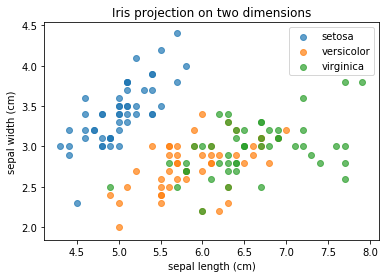

In [29]:
# GET /plots/scatter/:x/:y

#testing
if not KERNEL_GATEWAY:
    GATEWAY['request']['path'] = {'x':0, 'y':1}
    REQUEST  = json.dumps(GATEWAY['request'])

# request
req = json.loads(REQUEST)
x_index = int(req['path']['x'])
y_index = int(req['path']['y'])
   
fig, ax = plt.subplots()

for i in range(len(iris.target_names)):
    idx = iris.target==i
    ax.scatter(iris.data[idx, x_index], iris.data[idx, y_index], alpha=0.7, label=iris.target_names[i])

ax.legend()

plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.title("Iris projection on two dimensions")

render(plt)

In [13]:
# ResponseInfo GET /plots/scatter/:x/:y
response_info()

## Classification algorithms

#### Imports

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### Fitting the model

In [30]:
# GET /model/train/:x/:y

#testing
if not KERNEL_GATEWAY:
    GATEWAY['request']['path'] = {'x':0, 'y':1}
    GATEWAY['request']['args'] = {'model':[5]}
    REQUEST  = json.dumps(GATEWAY['request'])

req = json.loads(REQUEST)
x_index = int(req['path']['x'])
y_index = int(req['path']['y'])
selected_model = int(req['args']['model'][0])

from sklearn import neighbors
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

models = [
    neighbors.KNeighborsClassifier(n_neighbors=3),
    svm.SVC(kernel='linear'),
    svm.SVC(kernel='rbf'),
    svm.SVC(kernel='poly', degree=3),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(min_samples_leaf=4, max_depth=4)
]

model = models[selected_model]

# Select the data
X = iris.data[:,[x_index, y_index]]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, iris.target, random_state=0)

#fit on train data
model.fit(X_train, y_train) 

print(model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


#### Doing a prediction

In [31]:
# GET /model/predict

#testing
if not KERNEL_GATEWAY:
    GATEWAY['request']['args'] = {'variables':['5.0,2.2']}
    REQUEST  = json.dumps(GATEWAY['request'])

req = json.loads(REQUEST)
variables = [float(i) for i in req['args']['variables'][0].split(',')][0:2]

result = model.predict([variables,])
print(iris.target_names[result][0])

versicolor


#### Confusion Matrix

In [32]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

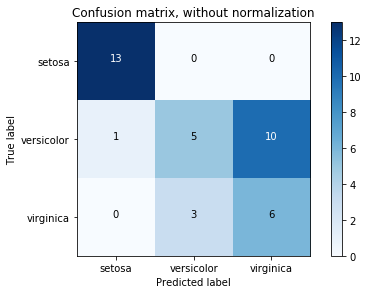

In [33]:
# GET /model/confusion/plot

#score on test data
y_pred = model.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=iris.target_names, title='Confusion matrix, without normalization')

render(plt)

In [34]:
# ResponseInfo GET /model/confusion/plot
response_info()

#### Predict the variable space with a mesh

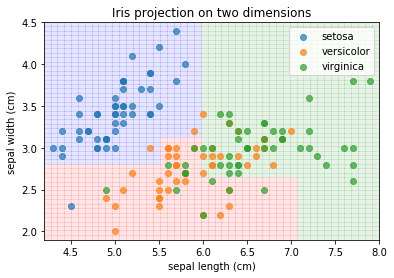

In [35]:
# GET /model/predict/plot

#boundaries
x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1 
y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1 

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),np.linspace(y_min, y_max, 50))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
cMap = ListedColormap(['b','r','g'])
ax.pcolormesh(xx, yy, Z, alpha=0.1, cmap=cMap)
for i in range(len(iris.target_names)):
    idx = iris.target==i
    ax.scatter(X[idx, 0], X[idx, 1], alpha=0.7, label=iris.target_names[i])

ax.legend()

plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.title("Iris projection on two dimensions")

render(plt)

In [ ]:
# ResponseInfo GET /model/predict/plot
response_info()